In [203]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

In [205]:
one_hot = True

In [256]:
num_steps = 2000
num_states = 25
attractor_center = 10
attractor_scale = 8
attractor_width = 2

if one_hot:
    dset = inputs.Sim1DFeeder(
        num_steps=num_steps, left_right_stay_prob=[1, 1, 1],
        num_states=num_states,
        attractor_center=attractor_center,
        attractor_scale=attractor_scale,
        attractor_width=attractor_width
        )
    save_path = '../trained_models/baseline/'
    model_path = save_path + 'model.pt'
    net_configs_path = save_path + 'net_configs.p'
    with open(net_configs_path, 'rb') as f:
        net_configs = pickle.load(f)
    net_configs.pop('num_states')
    net = STDP_SR(num_states=num_states, **net_configs)
    net.load_state_dict(torch.load(model_path))
else:
    sprs = 0.01536842105263158
    sig = 2.0
    sprs = 0.03
    sig = 2.5
    feature_maker_kwargs = {                                     
        'feature_dim': num_states,
        'feature_type': 'correlated_distributed',
        'feature_vals_p': [1-sprs, sprs], 'feature_vals': None,
        'spatial_sigma': sig
        }
    dset = sf_inputs_discrete.Sim1DFeeder(
        num_steps=num_steps, feature_maker_kwargs=feature_maker_kwargs,
        num_states=num_states,
        attractor_center=attractor_center,
        attractor_scale=attractor_scale,
        attractor_width=attractor_width
        )
    save_path = '/Volumes/aronov-locker/Ching/03_td_discrete_corr/'
    save_path += f'sparsity{sprs}/sigma{sig}/'
    save_path += '0.4/rnn/0/model.pt'
    ca3_kwargs = {
        'use_dynamic_lr': False, 'parameterize': True,
        'output_params':{'num_iterations': 13,'nonlinearity': 'clamp'}
        }
    net = AnalyticSR(
        num_states=num_states, gamma=0.7, ca3_kwargs=ca3_kwargs
        )
    net.load_state_dict(torch.load(save_path))

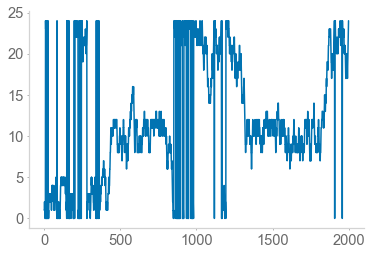

In [257]:
plt.figure()
window = dset.ys[:2000]
plt.plot(np.arange(window.size), window)
plt.show()

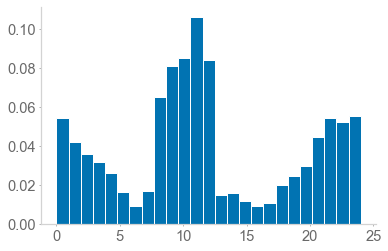

In [258]:
plt.figure()
plt.hist(
    dset.ys, weights=[1/dset.ys.size]*dset.ys.size,
    bins=num_states
    )
plt.show()

# Run network and divide into laps

In [259]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)

In [260]:
outputs = net(dg_inputs, dg_modes, reset=True)

In [273]:
M = net.get_M(gamma=0.95).detach().numpy().squeeze()

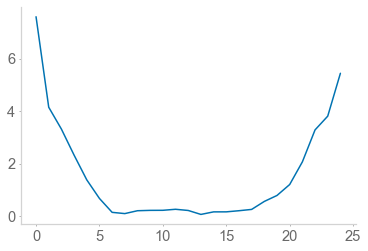

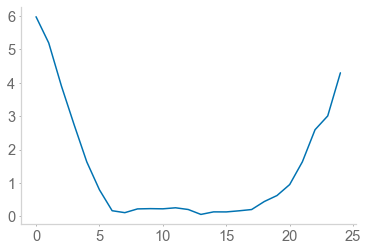

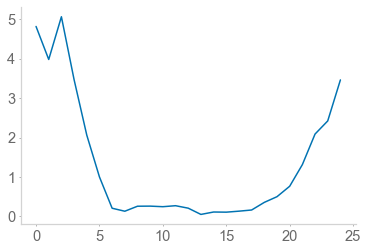

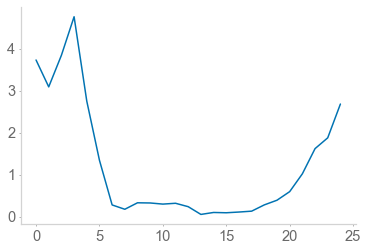

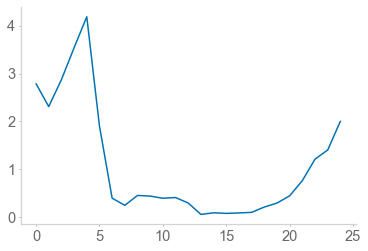

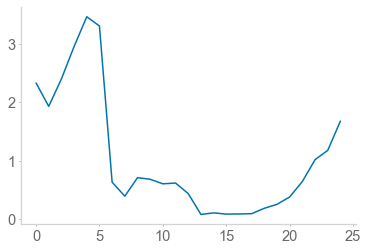

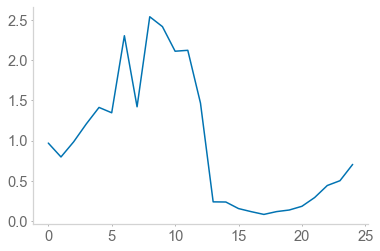

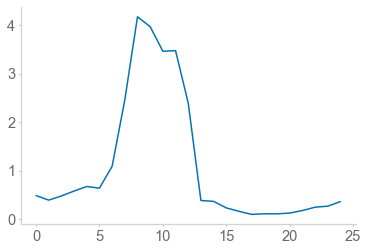

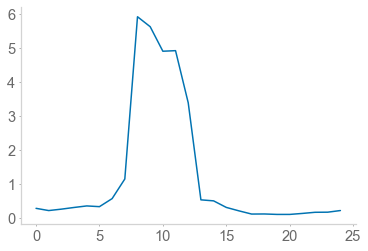

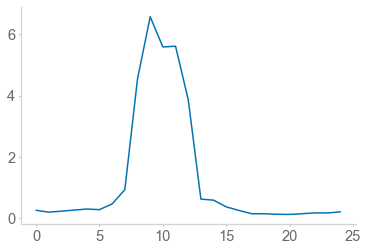

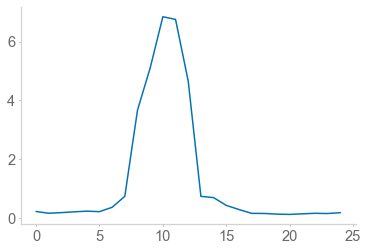

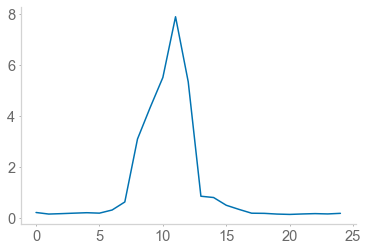

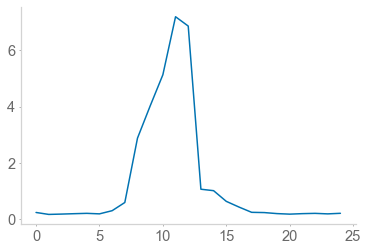

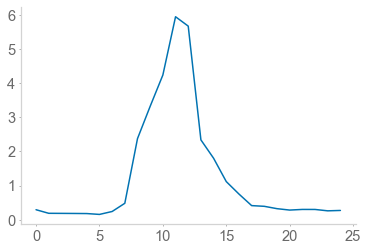

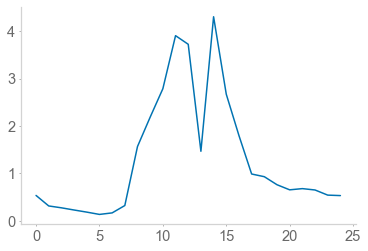

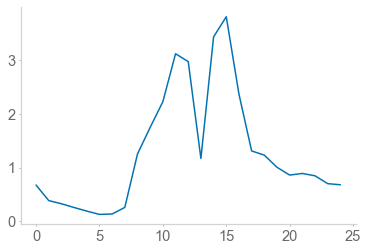

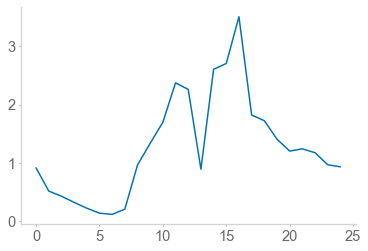

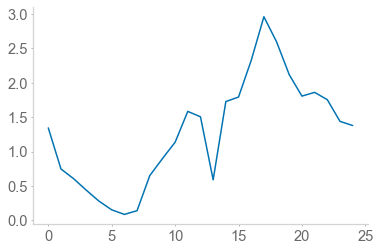

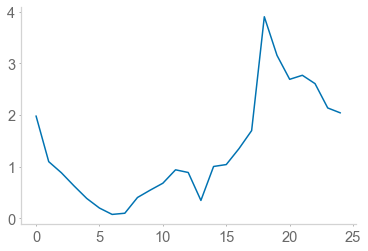

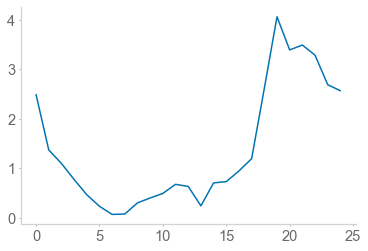

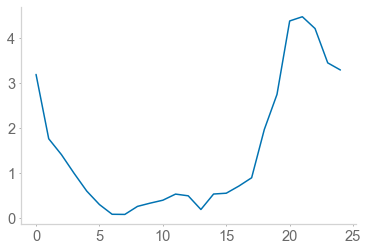

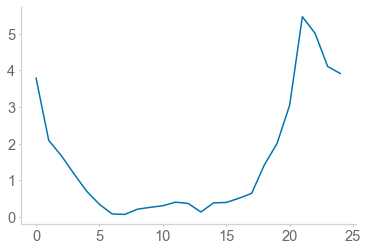

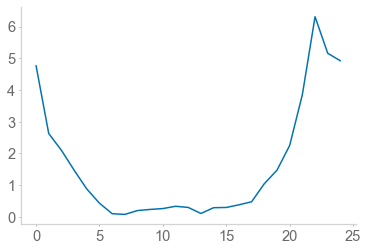

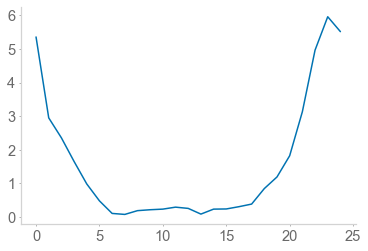

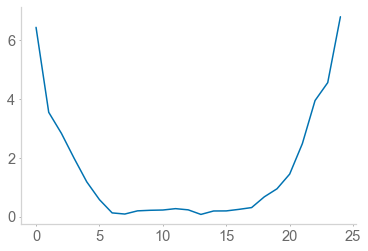

In [274]:
for i in range(num_states):
    plt.figure()
    plt.plot(M[i].tolist()*1)
    plt.show()

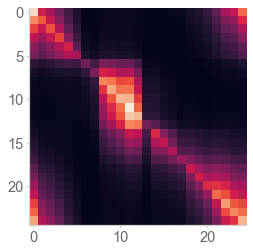

In [275]:
plt.figure()
plt.imshow(M)
plt.show()

# SF

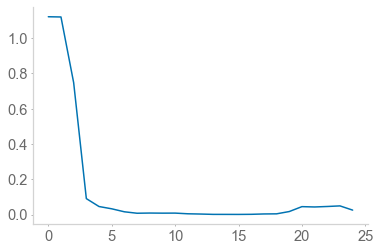

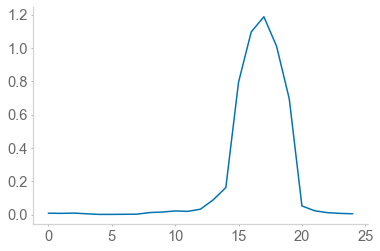

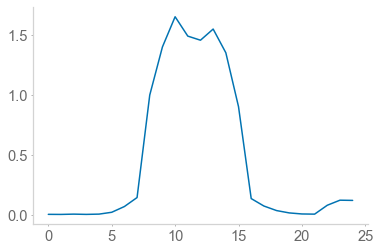

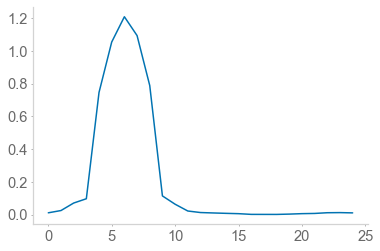

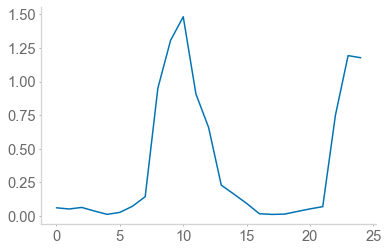

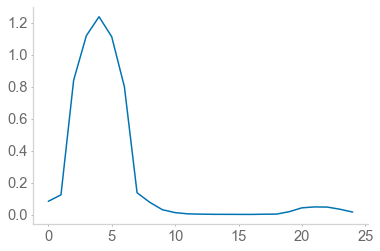

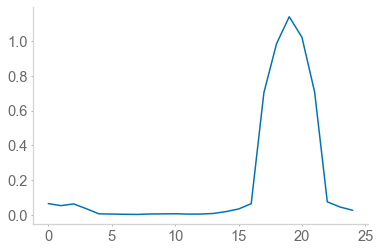

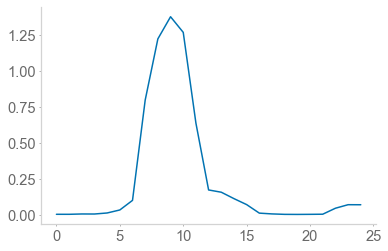

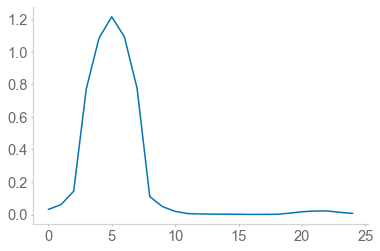

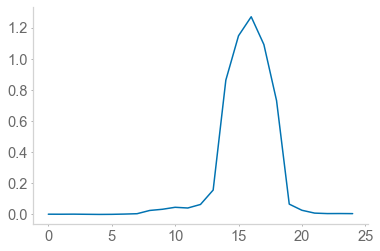

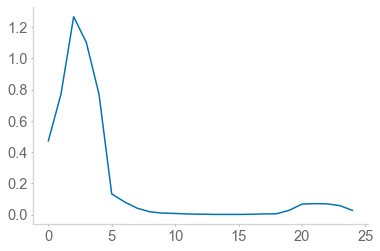

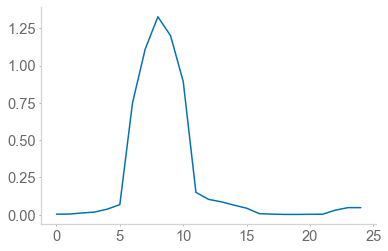

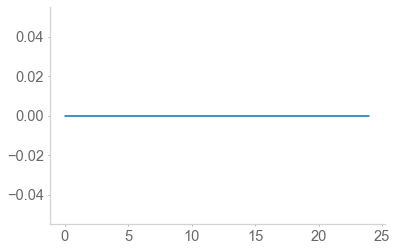

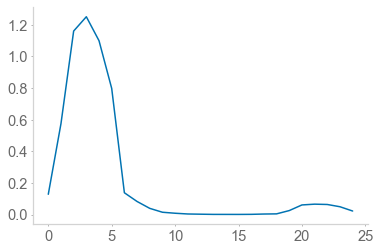

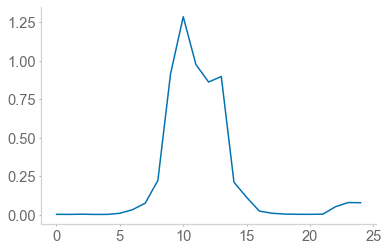

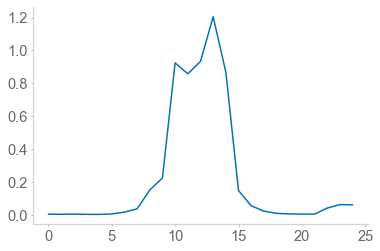

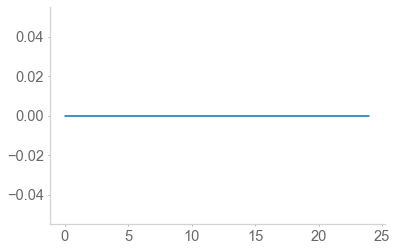

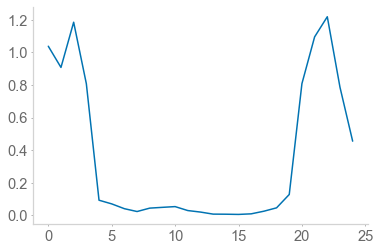

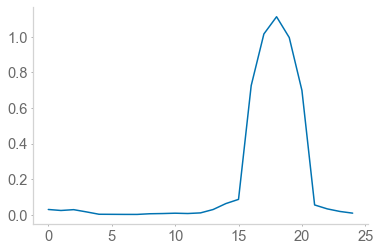

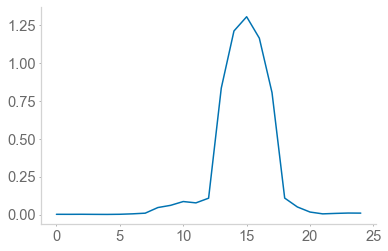

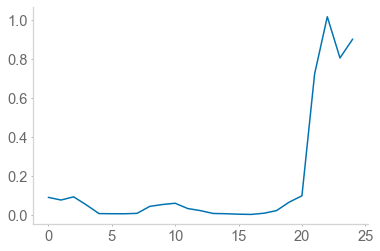

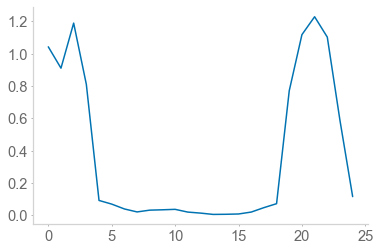

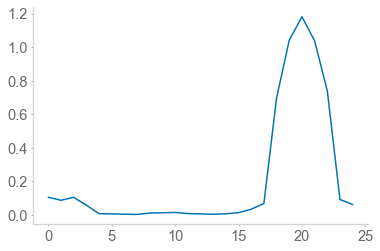

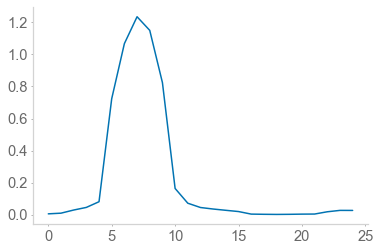

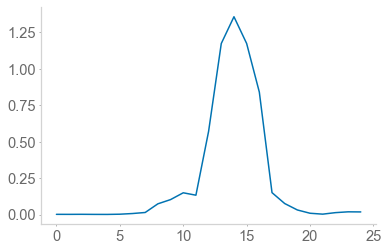

In [199]:
ff_M = []
for neur in range(num_states):
    ff = []
    for state in range(num_states):
        ff.append(np.mean(
            outputs[1][dset.ys==state,neur].detach().numpy()
            ))
    plt.figure()
    plt.plot(ff)
    plt.show()
    ff_M.append(ff)

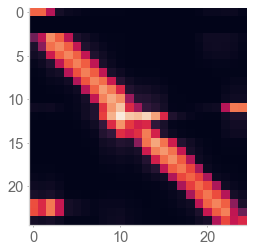

In [200]:
plt.figure()
ff_M = np.array(ff_M)
plt.imshow(ff_M[np.argsort(np.argmax(ff_M,axis=1)).astype(int),:])
plt.show()